Dyna Q model, CVAE, reward model and terminal model trained

In [1]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
name='Experiment1tlr'

In [3]:
from UCLSE.dyna_q.Experiment1d import Experiment
from UCLSE.dyna_q.dyna_q import TabularMemory
from UCLSE.dyna_q.benchmarking import BenchmarkAgent, SpoofAgent, DoNothing
import numpy as np
import pandas as pd
import os
import torch
import visdom
import matplotlib.pyplot as plt

In [4]:
vis=visdom.Visdom(port=8097)

In [5]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
            ans+=-1 #penalty
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why

In [6]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':6000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':True,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,15))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

lobenv_kwargs={'cutoff':100,'profit_target':10,'loss_limit':-1,'reward_func':reward_oracle,'lamb':0.5}
agent_kwargs={'CVAE':True,'Q_H1Size':16,'Q_H2Size':16,'latent_dim':3,'recon_weight':0.1,'kl_thresh':0.01,
                   'env_H1Size':16,'env_H2Size':16,
                   'doneModel':True,'rewardModel':None,'loss_func':None}


In [7]:
dyna_config={
	"double_q_model": False,
	"batch_size": 64,
	"learning_rate": 5e-3,
	"exploration": {
		"type": "exponential",
		"init_epsilon": 0.8,
		"min_epsilon": 0.05,
		"decay_steps": 100000,
		"decay_eps": 0.99,
        "choice":'least_bonus'
	},
	"memory": {
		"memory_capacity": 1000000,
		"prioritized": False,
        "tabular memory":True,
        
	},
	"discount": 0.99,
	"target_update_freq": 50,
	"first_update": 200,
	"modify_reward": False,
    "learn":'Q',
    'double_q_model':True,
    'model_update_freq':5,
    'planning_freq':5,
    'model':'CVAE'
    
}

In [8]:
experiment=Experiment(trader_pref_kwargs=trader_pref_kwargs,timer_kwargs=timer_kwargs,
           price_sequence_kwargs=price_sequence_kwargs,noise_kwargs=noise_kwargs,
           messenger_kwargs=messenger_kwargs,env_kwargs=env_kwargs,trader_kwargs=trader_kwargs,
           lobenv_kwargs=lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,dyna_kwargs=dyna_config,name=name)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory


In [9]:
experiment.new_train_setup(MaxEpisodes=1000,planning_steps=1,lookback=30,thresh=3,planning=True,graph=True)

In [10]:
experiment.agent.set_device()
experiment.train(MaxEpisodes=10001,start_episode=experiment.episode,folder='Results/'+experiment.name)

Device in use is  cuda
Planning is True, double Q model is True, tabular memory is True
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 21 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:-0.3788299340822394
Dyna-Q - EXP: 1 | Ep: 41 | timestep: 57 | Ep_r:  -1.7822584622943947 Profit: 0 Avg loss:-0.7724062653453387
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 61 | timestep: 100 | Ep_r:  0.25200035226502016 Profit: -1 Avg loss:-0.29208655473297906
Dyna-Q - EXP: 1 | Ep: 81 | timestep: 56 | Ep_r:  -0.9669456829972887 Profit: 1 Avg loss:0.11757564665669623
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 101 | timestep: 95 | Ep_r:  -2.8492714682209863 Profit: -2 Avg loss:-0.4596239703972183
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 121 | timestep: 12 | Ep_r:  

C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:720: UserWarning: not strict double Q model
  warnings.warn('not strict double Q model')


TEST episode 207, median 0.00396 | mean | -0.13788779085532663
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 208, median 0.00396 | mean | -0.1590043361302436
TEST episode 218, median 0.00396 | mean | 0.03837198494469819
TEST episode 219, median 0.00396 | mean | 0.1726906090529992
TEST episode 219, median 0.00396 | mean | 0.014260501169989562
Dyna-Q - EXP: 1 | Ep: 221 | timestep: 12 | Ep_r:  1.9924361012135483 Profit: 1 Avg loss:0.1799315342424102
TEST episode 220, median 0.00396 | mean | 0.1371999959725285
r0 0.5
TEST episode 220, median 0.6446850549484836 | mean | 0.2910520011877004
Saving best checkpoint at episode 220 with reward 0.11407115555555555
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 241 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.22706160504187925
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q -

C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1d.py:336: UserWarning: not strict double q, skipping
  warnings.warn('not strict double q, skipping')


TEST episode 502, median 0.0 | mean | 0.037822983029832696
TEST episode 503, median 0.0 | mean | -0.00865954559462804
r0 0.5
TEST episode 504, median 0.0 | mean | 0.1334216362999454
TEST episode 505, median 0.0 | mean | 0.23912848335919581
TEST episode 506, median 0.0 | mean | 0.25037062433708007
copying eval net to target net
r0 0.5
TEST episode 507, median 0.00198 | mean | 0.4281797436193858
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 507, median 0.62905199002 | mean | 0.4672272666219295
Saving best checkpoint at episode 507 with reward 0.2910520011877004
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 521 | timestep: 4 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.014599107588429742
Dyna-Q - EXP: 1 | Ep: 541 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.09788432170583689
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 561 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.0535300

Dyna-Q - EXP: 1 | Ep: 1461 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.4122990926686898
Dyna-Q - EXP: 1 | Ep: 1481 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.09305763084084907
Dyna-Q - EXP: 1 | Ep: 1501 | timestep: 9 | Ep_r:  2.0205931010065434 Profit: 1 Avg loss:0.424166533004019
TEST episode 1503, median 0.00780199002 | mean | 0.3526419233439121
REVERT BACK TO PRIOR NET
Dyna-Q - EXP: 1 | Ep: 1521 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.2586042929178629
Dyna-Q - EXP: 1 | Ep: 1541 | timestep: 8 | Ep_r:  1.018098162029232 Profit: 0 Avg loss:0.30333573008435916
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 1561 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.40681057159999273
Dyna-Q - EXP: 1 | Ep: 1581 | timestep: 13 | Ep_r:

adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 2001 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.4045771310767884
Saving checkpoint at episode 2000
r0 0.5
TEST episode 2004, median 0.18887717422836053 | mean | 0.23245829057817521
REVERT BACK TO PRIOR NET
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 2021 | timestep: 1 | Ep_r:  0.0 Profit: -5 Avg loss:0.47029330048507406
TEST episode 2021, median 0.06512717422836053 | mean | 0.2304928762098781
Dyna-Q - EXP: 1 | Ep: 2041 | timestep: 1 | Ep_r:  0.0 Profit: -3 Avg loss:0.5512514548593496
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 2061 | timestep: 14 | Ep_r:  0.048501674892408676 Profit: -1 Avg loss:0.3939170189769719
Dyna-Q - EXP: 1 | Ep: 2081 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.18314477486037717
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchang

Dyna-Q - EXP: 1 | Ep: 2681 | timestep: 2 | Ep_r:  0.00396 Profit: 29 Avg loss:0.20343809842900085
Dyna-Q - EXP: 1 | Ep: 2701 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.5596174642886983
TEST episode 2706, median 0.6232300000000001 | mean | 0.4447855559904767
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 2707, median 0.23846958698341786 | mean | 0.41199672438969703
r0 0.5
TEST episode 2708, median 0.6251902 | mean | 0.48631665169819005
TEST episode 2709, median 1.006761596 | mean | 0.5510219777547465
TEST episode 2709, median 1.006761596 | mean | 0.6429413468390408
TEST episode 2710, median 1.006761596 | mean | 0.6454418422817866
TEST episode 2710, median 1.006761596 | mean | 0.5542919393046711
TEST episode 2711, median 1.006761596 | mean | 0.5516781312913188
r0 0.5
TEST episode 2711, median 0.6232300000000001 | mean | 0.5574154912358767
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 2712, 

TEST episode 3108, median 0.0645695802007598 | mean | 0.1160318402501164
Dyna-Q - EXP: 1 | Ep: 3121 | timestep: 32 | Ep_r:  0.10204786561685855 Profit: -1 Avg loss:0.47820320794223325
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3141 | timestep: 32 | Ep_r:  1.9821792227904105 Profit: 1 Avg loss:0.031316138495207445
Dyna-Q - EXP: 1 | Ep: 3161 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.5655460099345575
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3181 | timestep: 5 | Ep_r:  1.01060398004 Profit: -2 Avg loss:0.5040003784799787
r0 0.5
TEST episode 3185, median 0.02819103744620434 | mean | 0.035037221361268474
r0 0.5
TEST episode 3186, median 0.0843101135935244 | mean | 0.07472700683929005
TEST episode 3187, median 0.04425894275455546 | mean | 0.03837012944869213
TEST episode 3188, median 0.13521066704666795 | mean | 0.30431864926614194
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 3189, median 0.08585019988513472 | mean |

TEST episode 3397, median 0.04894627143779902 | mean | 0.4198768416385735
TEST episode 3398, median 0.04894627143779902 | mean | 0.4135912920465405
TEST episode 3399, median 0.6232300000000001 | mean | 0.518041956686173
Dyna-Q - EXP: 1 | Ep: 3401 | timestep: 11 | Ep_r:  0.03390469829651342 Profit: -3 Avg loss:0.5771053930188214
TEST episode 3400, median 0.9989600000000001 | mean | 0.45133084132493295
TEST episode 3400, median 0.9989600000000001 | mean | 0.6675079844770626
TEST episode 3401, median 1.0009202 | mean | 0.7328946854281582
TEST episode 3401, median 1.01060398004 | mean | 0.7712429045824974
TEST episode 3402, median 1.01060398004 | mean | 0.8114043174853866
r0 0.5
TEST episode 3402, median 1.00674219002 | mean | 0.8092597273535893
TEST episode 3403, median 1.0028804 | mean | 0.7719252087152899
TEST episode 3403, median 1.0028804 | mean | 0.7096529868703789
TEST episode 3404, median 1.0028804 | mean | 0.6761068200160048
sequence made
adding exchange to RL trader  RL
adding ex

adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 3621 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.030047818789403023
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3641 | timestep: 13 | Ep_r:  1.0399915908004127 Profit: 0 Avg loss:0.0379586266954588
Dyna-Q - EXP: 1 | Ep: 3661 | timestep: 19 | Ep_r:  0.07639216142576534 Profit: -1 Avg loss:0.2345057204658957
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3681 | timestep: 29 | Ep_r:  0.09009098968414084 Profit: -1 Avg loss:0.15595439033136257
TEST episode 3682, median 0.610414293337163 | mean | 0.5993320150741983
TEST episode 3683, median 1.0028804 | mean | 0.6578762346619568
TEST episode 3683, median 1.00868278802 | mean | 0.8383355870942213
TEST episode 3684, median 1.0218834809218738 | mean | 0.9792251762329889
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 3684, median 1.0218834809218738

TEST episode 3820, median 1.0009202 | mean | 0.7334600157637384
r0 0.5
TEST episode 3821, median 1.0028804 | mean | 0.7651220186565936
r0 0.5
TEST episode 3821, median 1.004820998 | mean | 0.7827095084718473
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 3833, median 1.0028804 | mean | 0.7109699380105599
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 3833, median 1.0255746461126551 | mean | 0.9088056124119801
Saving best checkpoint at episode 3833 with reward 0.8813719745787875
r0 0.5
TEST episode 3839, median 1.0255746461126551 | mean | 0.9126209248558621
Dyna-Q - EXP: 1 | Ep: 3841 | timestep: 4 | Ep_r:  2.0017615959999997 Profit: 1 Avg loss:0.35531200880332475
TEST episode 3840, median 1.0162530511344159 | mean | 0.8074870942217681
TEST episode 3841, median 1.027420135501511 | mean | 0.9063059165200927
TEST episode 3842, median 1.014331859114416 | mean | 0.8693919380205997
copying eval net to 

adding exchange to RL trader  RL
TEST episode 4061, median 0.15453627523288266 | mean | -0.0024633823569963614
TEST episode 4062, median 0.2475 | mean | 0.1292014201825331
TEST episode 4063, median 0.6956890170935879 | mean | 0.28573462400415545
TEST episode 4064, median 0.31799881709358785 | mean | 0.1660728182651565
TEST episode 4065, median 0.6956890170935879 | mean | 0.14898524232683813
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
TEST episode 4066, median 1.004820998 | mean | 0.15914714426495427
TEST episode 4067, median 1.0105847681198 | mean | 0.195306452708275
TEST episode 4068, median 1.002860798 | mean | 0.1571279373251683
TEST episode 4069, median 1.0105847681198 | mean | 0.22380924591198686
TEST episode 4070, median 0.9989600000000001 | mean | 0.02878588063054562
TEST episode 4071, median 1.0009202 | mean | 0.05391255215002819
Dyna-Q - EXP: 1 | Ep: 4081 | timestep: 2 | Ep_r:  0.9989600000000001 Profit: 0 Avg loss:0.7943006942218821
Dyna-Q 

adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4761 | timestep: 11 | Ep_r:  2.027864698296513 Profit: 1 Avg loss:0.2958773456515889
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4781 | timestep: 12 | Ep_r:  0.037486051313548284 Profit: -1 Avg loss:0.2968292284128272
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4801 | timestep: 4 | Ep_r:  1.006761596 Profit: 30 Avg loss:0.42555964668651053
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4821 | timestep: 1 | Ep_r:  0.2475 Profit: 0 Avg loss:0.8926466988567461
Dyna-Q - EXP: 1 | Ep: 4841 | timestep: 63 | Ep_r:  2.946433981912283 Profit: 2 Avg loss:0.4913527887925669
Dyna-Q - EXP: 1 | Ep: 4861 | timestep: 3 | Ep_r:  0.0078804 Profit: -1 Avg loss:0.6245522998788794
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EX

Dyna-Q - EXP: 1 | Ep: 5641 | timestep: 3 | Ep_r:  1.0028804 Profit: 0 Avg loss:0.6551271157508839
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5661 | timestep: 4 | Ep_r:  0.011761596 Profit: -1 Avg loss:0.5126256634188827
Dyna-Q - EXP: 1 | Ep: 5681 | timestep: 2 | Ep_r:  0.9989600000000001 Profit: -2 Avg loss:0.31793067747948434
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5701 | timestep: 8 | Ep_r:  2.007002122228832 Profit: 1 Avg loss:0.2526534943629532
Dyna-Q - EXP: 1 | Ep: 5721 | timestep: 4 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.5972553672854388
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5741 | timestep: 21 | Ep_r:  1.0633048925118964 Profit: 0 Avg loss:0.47102926045317145
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  

adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6621 | timestep: 6 | Ep_r:  0.0154479402396 Profit: -1 Avg loss:0.5293326427488362
Dyna-Q - EXP: 1 | Ep: 6641 | timestep: 5 | Ep_r:  1.01060398004 Profit: -2 Avg loss:0.3613743216546046
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6661 | timestep: 62 | Ep_r:  1.173621787786733 Profit: 0 Avg loss:0.4932629954852639
Dyna-Q - EXP: 1 | Ep: 6681 | timestep: 10 | Ep_r:  -0.9450518151531218 Profit: -2 Avg loss:0.8128067556311327
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6701 | timestep: 8 | Ep_r:  4.006902122228832 Profit: 3 Avg loss:1.048165472692837
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6721 | timestep: 20 | Ep_r:  0.06487722496110765 Profit: -3 Avg loss:0.6516587245302576
sequence made
adding exchange to RL trade

adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7641 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.5145570558748862
Dyna-Q - EXP: 1 | Ep: 7661 | timestep: 3 | Ep_r:  1.0028804 Profit: 0 Avg loss:0.4527006870812513
Dyna-Q - EXP: 1 | Ep: 7681 | timestep: 42 | Ep_r:  0.1297763117703425 Profit: -1 Avg loss:0.5856956813065395
Dyna-Q - EXP: 1 | Ep: 7701 | timestep: 2 | Ep_r:  0.9989600000000001 Profit: 0 Avg loss:0.1880743759700841
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 7721 | timestep: 8 | Ep_r:  -1.973097877771168 Profit: -3 Avg loss:0.2327334024219985
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7741 | timestep: 2 | Ep_r:  0.00396 Profit: -1 Avg loss:0.4353843648622882
copying eval net to target net
sequence made
adding

Dyna-Q - EXP: 1 | Ep: 8541 | timestep: 12 | Ep_r:  0.037486051313548284 Profit: -1 Avg loss:0.7037881418039691
Dyna-Q - EXP: 1 | Ep: 8561 | timestep: 2 | Ep_r:  0.00396 Profit: -1 Avg loss:0.6648071643174422
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 8581 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.8243546630968389
Dyna-Q - EXP: 1 | Ep: 8601 | timestep: 1 | Ep_r:  0.0 Profit: -4 Avg loss:0.2903720867640967
Dyna-Q - EXP: 1 | Ep: 8621 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.1781096001204396
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8641 | timestep: 1 | Ep_r:  0.0 Profit: -3 Avg loss:0.35865002504750165
Dyna-Q - EXP: 1 | Ep: 8661 | timestep: 8 | Ep_r:  1.0219021222288318 Profit: 0 Avg loss:0.5866086079245292
copying eval net to target net
Dyna-Q - E

Dyna-Q - EXP: 1 | Ep: 9561 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.5975364794119133
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9581 | timestep: 4 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.472570326495794
Dyna-Q - EXP: 1 | Ep: 9601 | timestep: 3 | Ep_r:  1.0028804 Profit: 0 Avg loss:0.3967311990426518
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9621 | timestep: 12 | Ep_r:  0.04144605131354828 Profit: -1 Avg loss:0.2513587135644562
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9641 | timestep: 9 | Ep_r:  0.030593101006543638 Profit: -1 Avg loss:0.2740113712519345
Dyna-Q - EXP: 1 | Ep: 9661 | timestep: 6 | Ep_r:  1.0144079402396 Profit: 0 Avg loss:0.4452505349308408
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9681 | timestep: 4 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.6237809402730436
sequence made
adding exchange to RL trader  RL
adding exchange t

In [11]:
experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment1tlr\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment1tlr\dyna_best.pth.tar' (epoch 4145)


C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:809: UserWarning: not double Q
  warnings.warn('not double Q')
C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:826: UserWarning: No optimizer saved
  warnings.warn('No optimizer saved')


keys unused in checkpoint data:  ['episode', 'setup']


In [12]:
experiment.agent.set_device('cpu')
experiment.test_setup(MaxEpisodes=5000)

Device in use is  cpu
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory


C:\Users\micro_zo50ceu\OneDrive - University College London\BUCLSE\UCLSE\dyna_q\Experiment1a.py:555: UserWarning: no eval net for agent, skipping
  warnings.warn('no eval net for agent, skipping')


Dyna-Q - EXP 1, | Ep: , 1, | timestep:  40 | Ep_r: 0.16299860384037285|profit:-1 start:355|end:395
Dyna-Q - EXP 1, | Ep: , 26, | timestep:  2 | Ep_r: 0.00396|profit:-1 start:3922|end:3924
r0 1.0
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 51, | timestep:  26 | Ep_r: 0.08402274167793787|profit:-1 start:2502|end:2528
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 76, | timestep:  21 | Ep_r: -1.8527345167540026|profit:-3 start:627|end:648
Dyna-Q - EXP 1, | Ep: , 101, | timestep:  15 | Ep_r: 0.05197665814348459|profit:-1 start:4438|end:4453
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 126, | timestep:  13 | Ep_r: 1.0399915908004127|profit:0 start:2673|end:2686
r0 1.0
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 151, | timestep:  23 | Ep_r: -1.9957168279100244

Dyna-Q - EXP 1, | Ep: , 1301, | timestep:  20 | Ep_r: 0.06883722496110764|profit:-1 start:778|end:798
Dyna-Q - EXP 1, | Ep: , 1326, | timestep:  9 | Ep_r: -1.7194068989934563|profit:-2 start:4393|end:4402
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1351, | timestep:  56 | Ep_r: -1.7160612090218037|profit:-3 start:2422|end:2478
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1376, | timestep:  19 | Ep_r: 0.0655325504657653|profit:-1 start:610|end:629
Dyna-Q - EXP 1, | Ep: , 1401, | timestep:  23 | Ep_r: 1.0735542865425378|profit:0 start:3653|end:3676
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1426, | timestep:  28 | Ep_r: 0.09411228511854693|profit:-1 start:1876|end:1904
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1451, | timestep:  1 | Ep_r: 0.0|

Dyna-Q - EXP 1, | Ep: , 2601, | timestep:  28 | Ep_r: 1.0284851915030357|profit:0 start:1594|end:1622
r0 0.5
r0 0.5
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2626, | timestep:  2 | Ep_r: 0.00396|profit:-1 start:134|end:136
r0 1.0
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2651, | timestep:  16 | Ep_r: 2.0404668915620494|profit:1 start:4160|end:4176
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2676, | timestep:  31 | Ep_r: 0.14682817199184797|profit:-1 start:2299|end:2330
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2701, | timestep:  6 | Ep_r: 1.0144079402396|profit:0 start:140|end:146
Dyna-Q - EXP 1, | Ep: , 2726, | timestep:  12 | Ep_r: 1.0364460513135483|profit:0 start:3480|end:3492
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2751, | time

Dyna-Q - EXP 1, | Ep: , 3901, | timestep:  18 | Ep_r: 1.991567401804454|profit:1 start:2668|end:2686
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3926, | timestep:  3 | Ep_r: 1.0028804|profit:0 start:808|end:811
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3951, | timestep:  26 | Ep_r: 2.021743253177422|profit:1 start:28|end:54
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3976, | timestep:  25 | Ep_r: 1.0798714562403413|profit:0 start:3408|end:3433
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
r0 0.5
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4001, | timestep:  1 | Ep_r: 0.2475|profit:0 start:2297|end:2298
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4026, | timestep:  1 | Ep_r: 0.0|profit:-1 start:681|end:682
Dyna-Q - EXP 1, | Ep: , 4051, | timestep:  8 | Ep_r: 1.0219021222288318|profit:0 

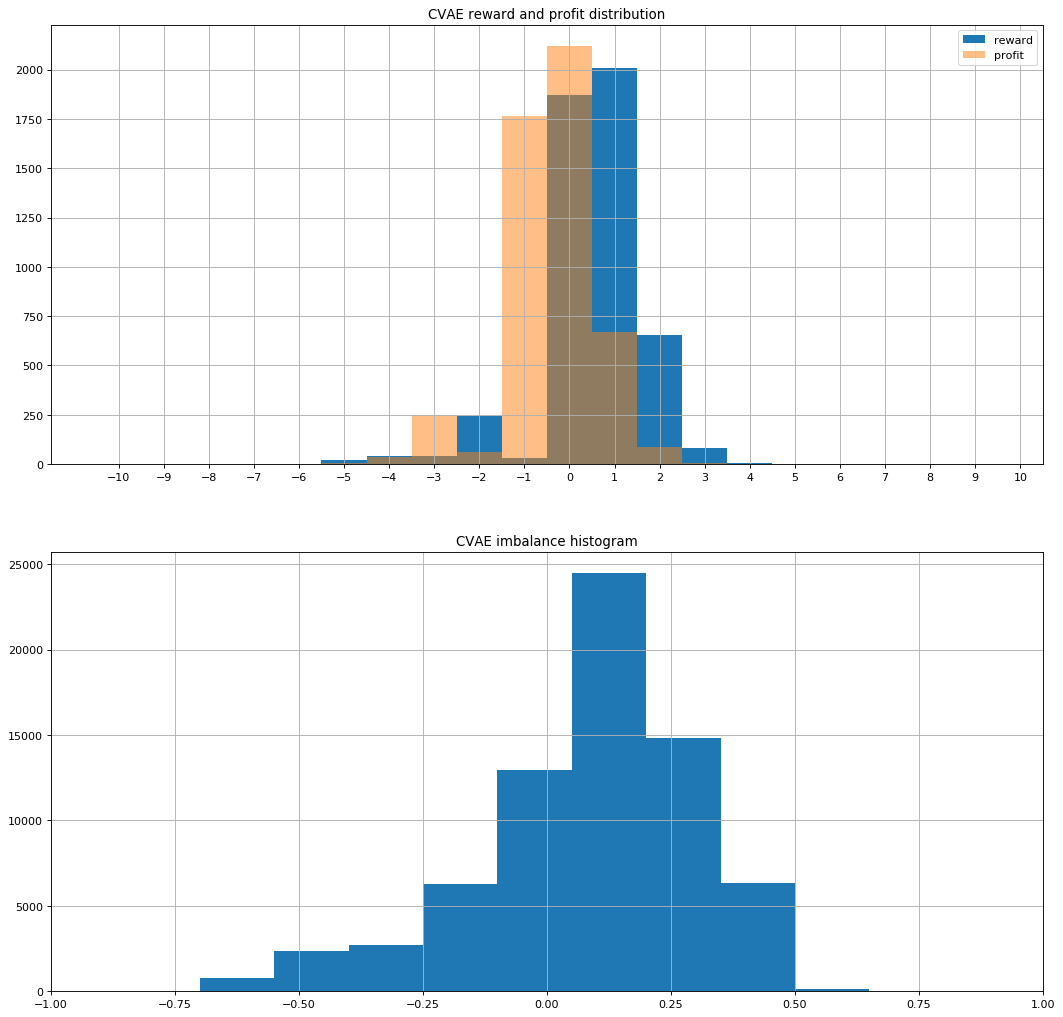

In [13]:
path='Results'
d,memory=experiment.plotbm_results(experiment,'CVAE reward and profit distribution',
                                   'CVAE imbalance histogram',name=experiment.name,path=path)

In [14]:
d.describe()

,reward,profit,start distance,duration
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.581467,-0.393800,0.097100,14.175000
std,1.135358,1.035633,0.018375,16.585119
min,-5.643278,-7.000000,-0.200000,1.000000
25%,0.003960,-1.000000,0.100000,3.000000
50%,1.002880,0.000000,0.100000,9.000000
75%,1.046977,0.000000,0.100000,18.000000
max,4.017865,3.000000,0.100000,100.000000


In [15]:
memory.n_inventory.value_counts(), memory.action.value_counts()

(1.0    66142
 0.0     4606
 2.0      127
 Name: n_inventory, dtype: int64, 2.0    64771
 4.0     4799
 1.0     1305
 Name: action, dtype: int64)

In [16]:
clf,train_score,test_score,importances=experiment.fit_tree(memory,os.path.join('Results',experiment.name),experiment)

In [17]:
train_score,test_score

(0.9696331550351682, 0.9707127282055668)

In [18]:
importances

,obs_name,importance,test_score,train_score
0,distance,0.018645,0.970713,0.969633
1,inventory,0.000000,0.970713,0.969633
2,orders_out,0.000000,0.970713,0.969633
3,bid_change,0.000000,0.970713,0.969633
4,ask_change,0.569537,0.970713,0.969633
5,bid_ask_spread,0.279472,0.970713,0.969633
6,position_in_lob,0.132346,0.970713,0.969633
7,imbalance,0.000000,0.970713,0.969633
8,time_left,0.000000,0.970713,0.969633
